# Fit a complete smooth model
### Optimize parameters for both a Sérsic source, a elliptical Sérsic lens light and a parametric lens model (SIE + shear)

__last updated__: 30/07/21

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import time
import corner
import numpy as np
from copy import deepcopy

# Basic JAX
import jax
from jax import lax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# JAX-ified lenstronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Util import image_util

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 20.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [4]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0., 'dec_0': 0.}]

# Lens light
lens_light_model_list = ['SERSIC_ELLIPSE']
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{'amp': 20.0, 'R_sersic': 3., 'n_sersic': 3., 'e1': 0.15, 'e2': -0.04, 'center_x': 0., 'center_y': 0.}]

kwargs_true = {
    'kwargs_lens': kwargs_lens_mass, 
    'kwargs_source': kwargs_source_light, 
    'kwargs_lens_light': kwargs_lens_light
}

### PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [6]:
# Noise
exp_time = 100
sigma_bkd = 0.05
kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)
noise_hybrid = deepcopy(noise)

### Image model

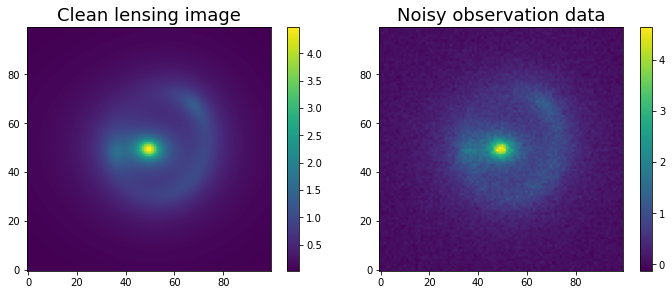

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = lens_image.model(**kwargs_true)

# Observed noisy data
data = lens_image.simulation(**kwargs_true)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Lens mass + source model fitting

### Parameter class

In [8]:
kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.5, 'e1': 0.1, 'e2': -0.02, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma1': 0., 'gamma2': 0.}],
    'kwargs_source': [{'amp': 18., 'R_sersic': 1.0, 'n_sersic': 1.3, 'center_x': 0.3, 'center_y': 0.1}],
    'kwargs_lens_light': [{'amp': 21., 'R_sersic': 2.8, 'n_sersic': 3.1, 'e1': 0.1, 'e2': -0.02, 'center_x': 1e-3, 'center_y': 1e-3}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{'amp': ['uniform', 15., 25.], 'R_sersic': ['uniform', 1., 2.], 'n_sersic': ['uniform', 1., 4.], 'center_x': ['uniform', -0.6, 0.6], 'center_y': ['uniform', -0.6, 0.6]}],
    'kwargs_lens_light': [{'center_x': ['uniform', -0.2, 0.2], 'center_y': ['uniform', -0.2, 0.2]}],
}
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

p_true = parameters.kwargs2args(kwargs_true)
p_init = parameters.kwargs2args(kwargs_init)
print("truths:", len(p_true), p_true)

print("priors:", parameters.prior_types)
print(parameters.bounds)
#print(parameters.log_prior(parameters.initial_values()))

truths: 19 [ 1.6e+00  1.5e-01 -4.0e-02  0.0e+00  0.0e+00 -1.0e-02  3.0e-02  2.0e+01
  1.2e+00  1.5e+00  4.0e-01  1.5e-01  2.0e+01  3.0e+00  3.0e+00  1.5e-01
 -4.0e-02  0.0e+00  0.0e+00]
priors: [None, None, None, None, None, None, None, 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', None, None, None, None, None, 'uniform', 'uniform']
(array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, 15. ,  1. ,  1. , -0.6,
       -0.6, -inf, -inf, -inf, -inf, -inf, -0.2, -0.2]), array([ inf,  inf,  inf,  inf,  inf,  inf,  inf, 25. ,  2. ,  4. ,  0.6,
        0.6,  inf,  inf,  inf,  inf,  inf,  0.2,  0.2]))


### Loss function

In [9]:
# Create loss
loss = Loss(data, lens_image, parameters, 
            likelihood_type='chi2', prior_terms=None)

print("Loss at init:", loss(p_init))
print("Loss at true:", loss(p_true))

Loss at init: 1.760733589087359
Loss at true: 1.0097742706712627


### Minimize the loss function over all parameters using scipy
Since scipy.minimize() takes a 1D input array of parameters, we have to make the nested dictionary of params used by the loss function above compatible with this. The code below is rather clumsy and could certainly be generalised to allow the user to decide (i.e. switch on and off) which parameters to fix and which to include in the fit.

In [10]:
# Optimise !
optimizer = Optimizer(loss, parameters)
best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True, 
                         use_exact_hessian_if_allowed=False)
print(f"Runtime: {runtime}")
kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))

Runtime: 7.364891052246094


{'kwargs_lens': [{'theta_E': array(1.60411302), 'e1': array(0.14580724), 'e2': array(-0.04759687), 'center_x': array(0.00843268), 'center_y': array(-0.00709179)}, {'gamma1': array(-0.01460014), 'gamma2': array(0.02734618), 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': array(18.16736367), 'R_sersic': array(1.29068517), 'n_sersic': array(1.56765706), 'center_x': array(0.39912588), 'center_y': array(0.14400266)}], 'kwargs_lens_light': [{'amp': array(21.05788604), 'R_sersic': array(2.89690348), 'n_sersic': array(2.95972363), 'e1': array(0.15688572), 'e2': array(-0.03510034), 'center_x': array(-0.00174079), 'center_y': array(0.00068141)}]}


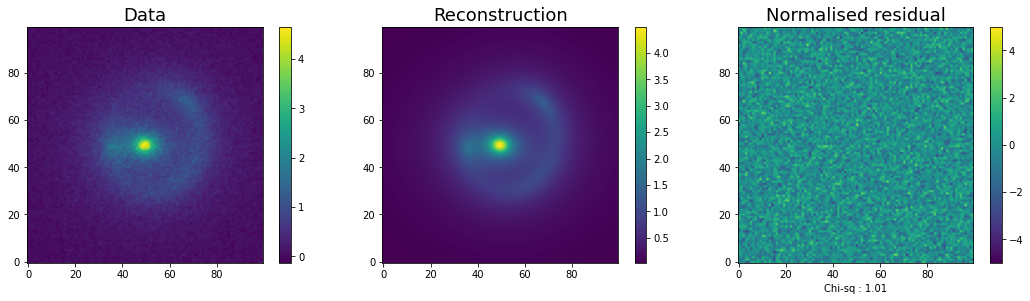

In [11]:
def plot_image_model(kwargs):
    rec = lens_image.model(**kwargs)
    noise_var = lens_image.Noise.C_D

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ax1, ax2, ax3 = axes
    img1 = ax1.imshow(data, origin='lower')
    ax1.set_title("Data", fontsize=FS)
    img2 = ax2.imshow(rec, origin='lower')
    ax2.set_title("Reconstruction", fontsize=FS)
    img3 = ax3.imshow((data - rec) / np.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
    ax3.set_title("Normalised residual", fontsize=FS)
    red_chi2 = np.mean((data - rec)**2 / noise_var)
    ax3.set_xlabel(f"Chi-sq : {red_chi2:.2f}")
    for img, ax in zip((img1, img2, img3), axes):
        fig.colorbar(img, ax=ax)
    fig.tight_layout()

print(kwargs_final)
plot_image_model(kwargs_final)

In [12]:
def print_errors(kwargs):
    def print_error_sgl(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} %")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} (abs)")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_lens_mass):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            print_error_sgl(key, value, fit)
    for params in kwargs_source_light:
        for key, value in params.items():
            fit = kwargs['kwargs_source'][0][key]
            print_error_sgl(key, value, fit)
    for i, params in enumerate(kwargs_lens_light):
        for key, value in params.items():
            fit = kwargs['kwargs_lens_light'][i][key]
            print_error_sgl(key, value, fit)
        
print_errors(kwargs_final)

Error
-----
theta_E:   0.26 %
e1:        2.80 %
e2:        -18.99 %
center_x:  0.01 (abs)
center_y:  0.01 (abs)
gamma1:    -46.00 %
gamma2:    8.85 %
ra_0:      0.00 (abs)
dec_0:     0.00 (abs)
amp:       9.16 %
R_sersic:  7.56 %
n_sersic:  4.51 %
center_x:  0.22 %
center_y:  4.00 %
amp:       5.29 %
R_sersic:  3.44 %
n_sersic:  1.34 %
e1:        4.59 %
e2:        -12.25 %
center_x:  0.00 (abs)
center_y:  0.00 (abs)


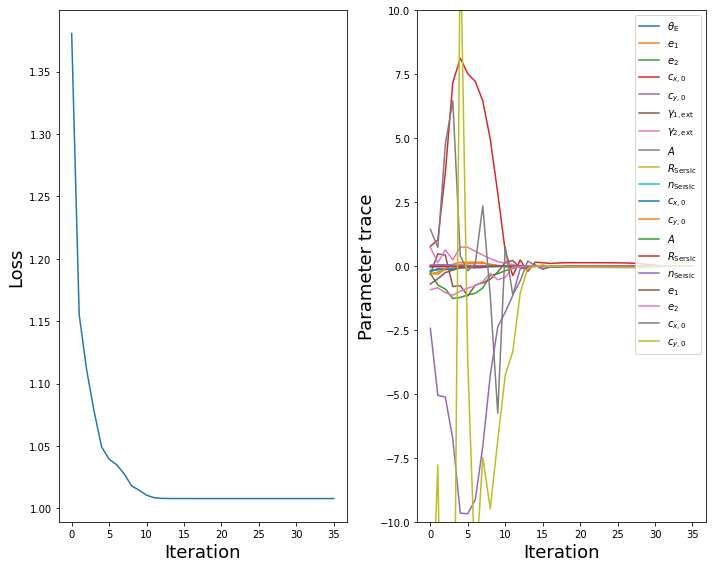

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
ax = axes[0]
ax.plot(range(len(optimizer.loss_history)), optimizer.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax = axes[1]
param_history = np.array(optimizer.param_history)
for i in range(len(parameters.symbols)):
    ax.plot(range(len(optimizer.loss_history)), (param_history[:, i] - param_history[-1, i]) / param_history[-1, i], label=parameters.symbols[i])
ax.set_ylabel("Parameter trace", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(loc='upper right')
ax.set_ylim(-10, 10)
fig.tight_layout()
plt.show()

### Fisher matrix

Using approximated inverse Hessian


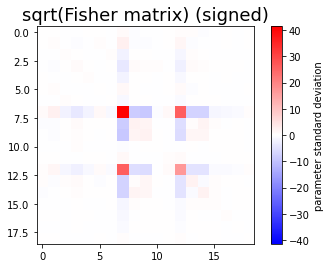

In [14]:
allow_true_hessian = False

if extra_fields['hess_inv'] is not None:
    print("Using approximated inverse Hessian")
    fisher_matrix = extra_fields['hess_inv']
elif allow_true_hessian:
    print("Using true inverse Hessian")
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)
else:
    fisher_matrix = None
    
if fisher_matrix is not None:
    sqrt_fisher_matrix = np.sqrt(np.abs(fisher_matrix)) * np.sign(fisher_matrix)
    plt.title("sqrt(Fisher matrix) (signed)", fontsize=FS)
    plt.imshow(sqrt_fisher_matrix, cmap='bwr', vmin=-np.abs(sqrt_fisher_matrix).max(), vmax=np.abs(sqrt_fisher_matrix).max())
    plt.colorbar(label="parameter standard deviation")
    plt.show()

/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


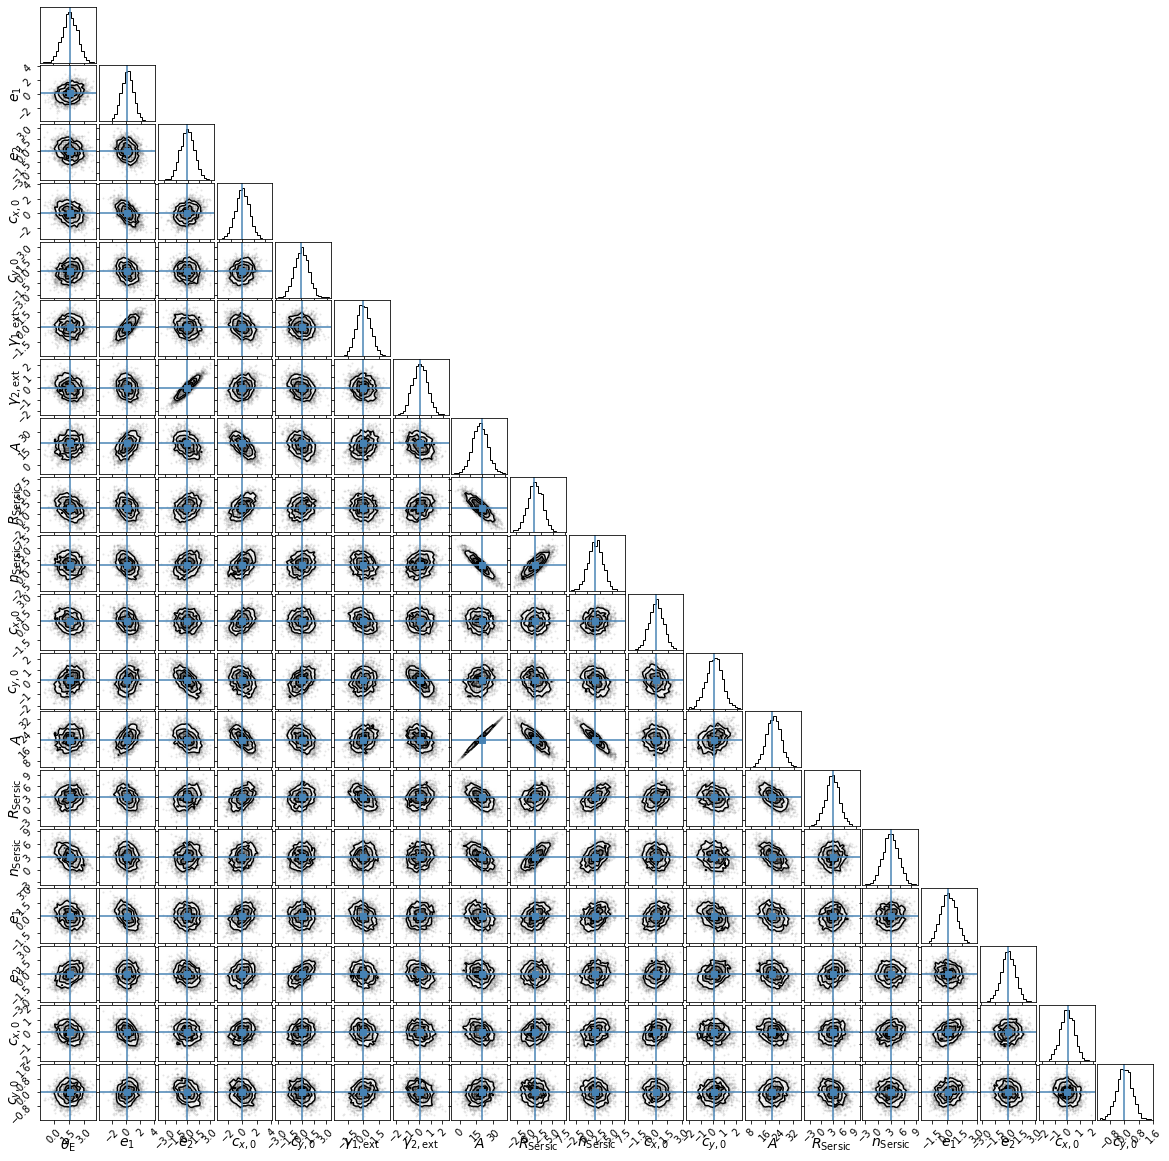

In [15]:
def draw_from_gaussian(mu, S, ndraws=1):
    ndim = len(mu)
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

samples_fisher = draw_from_gaussian(best_fit, sqrt_fisher_matrix, ndraws=3000)

fig = plt.figure(figsize=(16, 16))
fig = corner.corner(samples_fisher, truths=p_true, show_titles=False, labels=parameters.symbols, 
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()